In [8]:
!conda env list

# conda environments:
#
base                     /home/tymon/miniconda3
darwin-personal       *  /home/tymon/miniconda3/envs/darwin-personal
test_env                 /home/tymon/miniconda3/envs/test_env



In [19]:
# !conda env list 
# run conda activate <env_name> before opening the notebook
# if the keras_vggface is missing, install it manually (for now)
# pip install git+https://github.com/rcmalli/keras-vggface.git

import tensorflow as tf
import keras
import keras_vggface
import mtcnn
import matplotlib
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from keras_vggface.utils import preprocess_input
from keras_vggface.utils import decode_predictions
from keras_vggface.vggface import VGGFace


print(tf.__version__)
print(keras_vggface.__version__)
print(mtcnn.__version__)


def extract_face(frame, face_detector, required_size=(224, 224)):
    """
		Detects and extracts a face from the image
	
		Parameters
		----------
		frame : ndarray (? * ? * 3)
			An RGB array image
		
		face_detector : object
			An MTCNN object for face detection
	
		Returns
		-------
		face : ndarray (224 * 224 * 3) default
			A face extracted from the original image, resized to required size
	"""
    # detect faces in the image
    results = face_detector.detect_faces(frame)
    # extract the bounding box from the first face
    x1, y1, width, height = results[0]['box']
    x2, y2 = x1 + width, y1 + height
    # extract the face
    face = frame[y1:y2, x1:x2]
    # resize pixels to the model size
    image = Image.fromarray(face)
    image = image.resize(required_size)
    face_array = np.asarray(image)
    return face_array

2.1.0
0.6
0.1.0


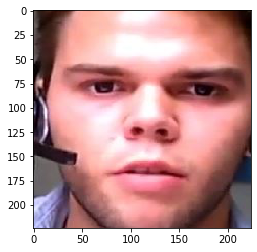

In [10]:
filename = 'data/example_face.JPG'
det = mtcnn.MTCNN()
frame = plt.imread(filename)
face = extract_face(frame, det)
plt.imshow(face)
plt.show()

In [21]:
def facenet_encoding(faces):
	"""
		Encodes an image of a face into a lower dimensional representation

		Parameters
		----------
		faces : ndarray (n * 160 * 160 * 3)
			An array of face images to be encoded

		Returns
		-------
		encoding : ndarray (n * 128)
			Feature-vector of a face representations
	"""
	
	scaled_faces = (faces - faces.mean()) / faces.std()  # Standardise across channels
	
	facenet = models.load_model('models/facenet_keras.h5', compile=False)
	encoding = facenet.predict(scaled_faces)
	
	return encoding

def vggface_encoding(faces):
    """
		Encodes an image of a face into a lower dimensional representation

		Parameters
		----------
		faces : ndarray (n * 160 * 160 * 3)
			An array of face images to be encoded

		Returns
		-------
		encoding : ndarray (n * 8631)
			Feature-vector of a face representations
	"""
    scaled_faces = (faces - faces.mean()) / faces.std()  # Standardise across channels
    # example of creating a face embedding
    # create a vggface2 model
    # convolution features
    model = VGGFace(include_top=False, model='resnet50', 
                    input_shape = (224, 224, 3), pooling='avg')
    # if we want the top fully-connected layers.
    #     model = VGGFace(model='resnet50') 
    #     print('Inputs: %s' % model.inputs)
    #     print('Outputs: %s' % model.outputs)
    #     print(face.shape)
    yhat = model.predict(faces)
    return yhat

In [22]:
face2 = face 
k = np.array([face, face2])
k.shape

(2, 224, 224, 3)

In [33]:
faces = np.reshape(face, (-1, 224, 224, 3)) # dirty
pred = vggface_encoding(faces)
pred.shape

(1, 2048)

In [31]:
vgg_model = VGGFace(model='resnet50')
wanted_layer = 'conv5_3_3x3' #stage<=5, block<=6
out = vgg_model.get_layer(wanted_layer).output
r = keras.layers.Flatten()(out)
custom_vgg_model = keras.engine.Model(vgg_model.input, r)
k = custom_vgg_model.predict(faces)

In [32]:
k.shape

(1, 25088)

deep features (yhat) are to be rank normalized between 0 and 1.